# **Task 1 : Training a Deep Learning Model for Sudoku Digit Recognition**

# Introduction
This Notebook demonstrates the process of training a deep learning model to recognize digits and their positions in a Sudoku puzzle. The task involves using a dataset of partially solved Sudoku puzzles to train a model that can accurately identify the filled digits and their positions within the grid.


# Data Loading
First, we load the training and test datasets. The training data consists of images of partially solved Sudoku puzzles and their corresponding labels, indicating the positions and values of the filled digits. The test data comprises images of Sudoku puzzles that the model will attempt to solve.


In [ ]:
import numpy as np

path_to_training_images = '/kaggle/input/traindata/imgs-001.npy'
path_to_training_labels = '/kaggle/input/traindata/known_values_labels.npy'
path_to_test_images = '/kaggle/input/testdata/imgs.npy'

# Load the files
training_images = np.load(path_to_training_images)
training_labels = np.load(path_to_training_labels)
test_images = np.load(path_to_test_images)

# Checking the shape of the loaded arrays
print("Training Images Shape:", training_images.shape)
print("Training Labels Shape:", training_labels.shape)
print("Test Images Shape:", test_images.shape)


# Data Visualization
Visualizing a subset of the training and test images to understand the data better. 

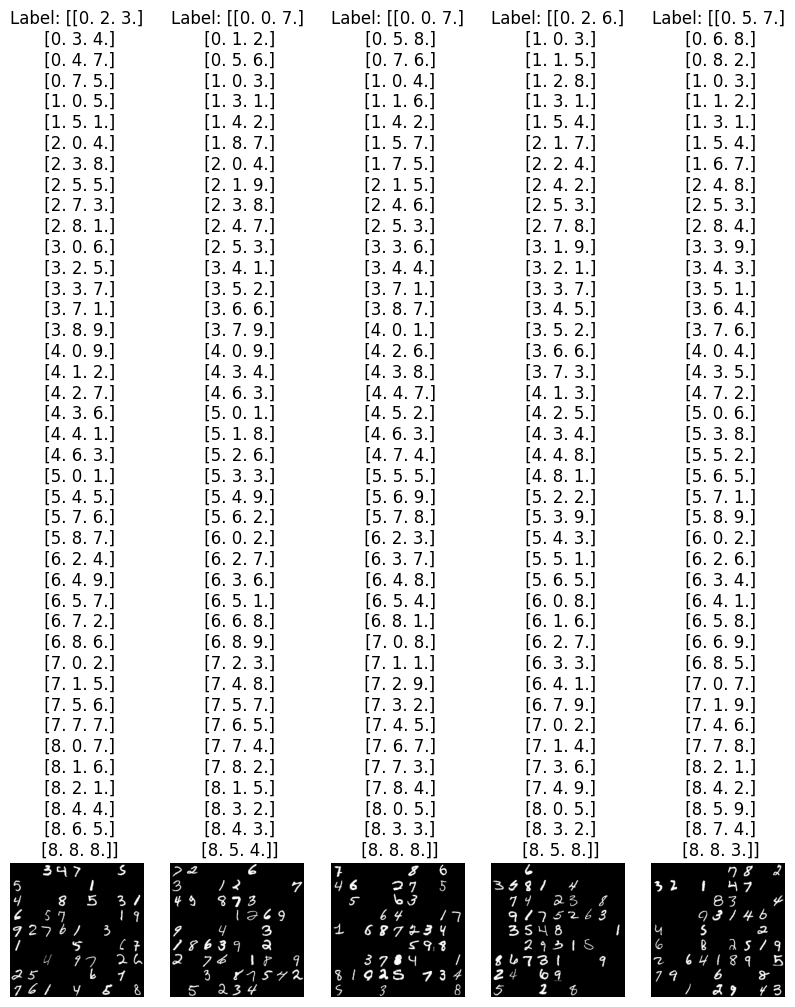

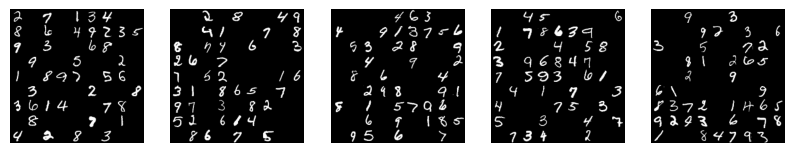

In [12]:
import matplotlib.pyplot as plt

def plot_images(images, labels=None, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(10, 2))
    for i, ax in enumerate(axes):
        ax.imshow(images[i], cmap='gray')
        ax.axis('off')
        if labels is not None:
            ax.set_title(f'Label: {labels[i]}')

# Display the first 5 training images and labels
plot_images(training_images[:5], [str(label) for label in training_labels[:5]])

# Display the first 5 test images
plot_images(test_images[:5])

plt.show()

# Data Preprocessing
Before training, we need to preprocess the data. This includes extracting individual cells from the Sudoku grids and normalizing the pixel values. The preprocessed data is then wrapped in a custom PyTorch `Dataset` for efficient loading.


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn, optim
import torch.nn.functional as F


def extract_cells(sudoku_grid):
    cell_length = sudoku_grid.shape[0] // 9
    cells = []

    for r in range(9):
        for c in range(9):
            cell = sudoku_grid[r*cell_length:(r+1)*cell_length, c*cell_length:(c+1)*cell_length]
            cells.append(cell)

    return cells


In [14]:
class CustomSudokuDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        grid_image = self.images[idx]
        grid_labels = self.labels[idx]
        cells = extract_cells(grid_image)

        cell_images = []
        cell_labels = []

        for label in grid_labels:
            r, c, val = int(label[0]), int(label[1]), int(label[2])
            if val > 0:
                cell_idx = r * 9 + c
                cell_image = cells[cell_idx].flatten()
                if self.transform:
                    cell_image = self.transform(cell_image.reshape(28, 28))
                cell_images.append(cell_image)
                cell_labels.append(val)

        return torch.stack(cell_images), torch.tensor(cell_labels, dtype=torch.int64)


In [15]:
from torch.utils.data import random_split


# Transformation
data_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5,), (0.5,))])

# Dataset
sudoku_dataset = CustomSudokuDataset(training_images, training_labels, transform=data_transform)

# Splitting
train_size = int(0.8 * len(sudoku_dataset))
val_size = len(sudoku_dataset) - train_size
train_set, val_set = random_split(sudoku_dataset, [train_size, val_size])

# DataLoader
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64)


# Model Definition
Defining the neural network model for digit recognition. The model consists of several fully connected layers and uses ReLU activations and a softmax output layer for classification.


In [16]:
class SudokuNN(nn.Module):
    def __init__(self):
        super(SudokuNN, self).__init__()
        self.fc1 = nn.Linear(784, 128)  # 28x28 flattened
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)
        return x

model = SudokuNN()

# Training and Evaluation
Training the model using the prepared datasets. Evaluating the model's performance on a validation set to assess its generalization ability.

Epoch 1/15, Training Loss: 0.7113, Training Accuracy: 80.46%
Validation Loss: 0.3380, Validation Accuracy: 90.02%
Epoch 2/15, Training Loss: 0.3029, Training Accuracy: 91.05%
Validation Loss: 0.2768, Validation Accuracy: 91.81%
Epoch 3/15, Training Loss: 0.2525, Training Accuracy: 92.63%
Validation Loss: 0.2306, Validation Accuracy: 93.34%
Epoch 4/15, Training Loss: 0.2091, Training Accuracy: 93.98%
Validation Loss: 0.1903, Validation Accuracy: 94.55%
Epoch 5/15, Training Loss: 0.1730, Training Accuracy: 95.07%
Validation Loss: 0.1582, Validation Accuracy: 95.58%
Epoch 6/15, Training Loss: 0.1450, Training Accuracy: 95.93%
Validation Loss: 0.1338, Validation Accuracy: 96.26%
Epoch 7/15, Training Loss: 0.1236, Training Accuracy: 96.52%
Validation Loss: 0.1150, Validation Accuracy: 96.77%
Epoch 8/15, Training Loss: 0.1067, Training Accuracy: 96.97%
Validation Loss: 0.1000, Validation Accuracy: 97.14%
Epoch 9/15, Training Loss: 0.0932, Training Accuracy: 97.36%
Validation Loss: 0.0880, Va

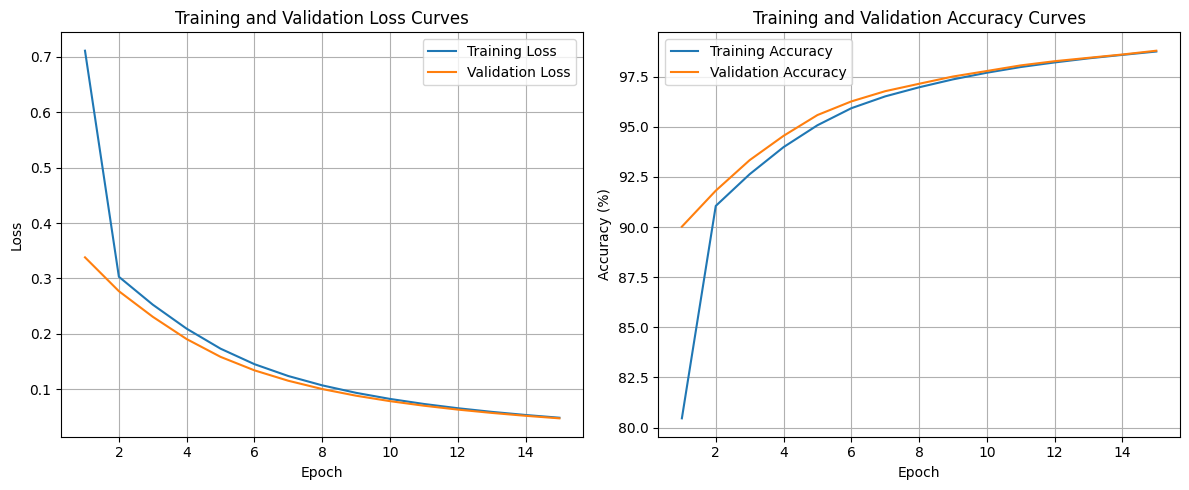

In [17]:
import matplotlib.pyplot as plt

def train_and_validate_model(model, train_loader, val_loader, epochs=15):
    criterion = nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses = []   # To store training losses for each epoch
    val_losses = []     # To store validation losses for each epoch
    train_accuracies = []  # To store training accuracies for each epoch
    val_accuracies = []    # To store validation accuracies for each epoch

    for epoch in range(epochs):
        model.train()  # Set model to training mode
        total_loss = 0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.view(-1, 784).to(device), labels.view(-1).to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            _, predicted = torch.max(output.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = total_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train

        # Store training loss and accuracy
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        print(f'Epoch {epoch + 1}/{epochs}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%')

        # Validation
        model.eval()  # Set model to evaluation mode
        correct_val = 0
        total_val = 0
        val_loss = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.view(-1, 784).to(device), labels.view(-1).to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct_val / total_val

        # Store validation loss and accuracy
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

    # Plotting
    plt.figure(figsize=(12, 5))

    # Loss curves
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss Curves')
    plt.grid(True)

    # Accuracy curves
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Training and Validation Accuracy Curves')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Execute the training and validation function
train_and_validate_model(model, train_loader, val_loader, epochs=15)


In [9]:
model_file_path = '/kaggle/input/model/sudoku_model.pth'

torch.save(model.state_dict(), model_file_path)

print(f"Model saved to {model_file_path}")

'/kaggle/input/model/sudoku_model.pth'

In [10]:
#loaded_model = SudokuNN()

#loaded_model.load_state_dict(torch.load('/kaggle/input/model/sudoku_model.pth'))

#loaded_model.eval()

#print("Model loaded successfully.")

Model loaded successfully.


# Prediction on Test Images

In [14]:
import pandas as pd

model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def normalize_cell(cell_image):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    cell_tensor = transform(cell_image)
    return cell_tensor.view(1, -1)

num_images = test_images.shape[0]

predictions = []

for image_id in range(num_images):
    for row in range(9):
        for col in range(9):
            cell_image = test_images[image_id, row*28:(row+1)*28, col*28:(col+1)*28]
            cell_tensor = normalize_cell(cell_image)

            with torch.no_grad():
                output = model(cell_tensor)
                _, predicted = torch.max(output.data, 1)

            predictions.append((f"{image_id}_{row}{col}", predicted.item() + 1))  # Adjust for 1-9 range

submission_df = pd.DataFrame(predictions, columns=["id", "value"])
submission_df.to_csv('submission.csv', index=False)


Kaggle Result for this approach: **0.75754**


# **Approach 2: Leveraging MNIST Dataset for Pre-training**
In the second approach, I pre-training our model on the MNIST dataset, renowned for handwritten digit classification. This technique aims to provide a robust foundational knowledge to our model, enhancing its performance on the Sudoku digit recognition task.

In [2]:
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F


# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# MNIST Dataset Preparation
The MNIST dataset is loaded with the defined transformations, and DataLoader objects are prepared for both training and testing phases.

In [3]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize MNIST images to 64x64
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Reload MNIST dataset with updated transformations
train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create dataloaders
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

print("Datasets reloaded with resized images.")


100%|██████████| 9912422/9912422 [00:00<00:00, 99214438.51it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 62797145.58it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 25052766.67it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6582767.37it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Datasets reloaded with resized images.


# Model Architecture
The model architecture is defined, tailored for digit recognition tasks. This Convolutional Neural Network is designed to accommodate the resized MNIST images.

In [8]:
class SudokuCNN(nn.Module):
    def __init__(self):
        super(SudokuCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.fc1 = nn.Linear(64 * 16 * 16, 500)  # Adjusted for 64x64 images
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Create the updated model instance
model = SudokuCNN().to(device)

print("Model updated for resized images.")

Model updated for resized images.


# Training and Evaluating the Model on MNIST
The model is trained on the MNIST dataset using a standard training loop with Cross-Entropy Loss and the Adam optimizer.Post-training, the model's performance is evaluated on the MNIST test set to confirm its effectiveness in digit classification.

In [9]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Loss function and optimizer set.")


Loss function and optimizer set.


Epoch [1/10], Training Loss: 0.1254, Training Accuracy: 96.27%, Validation Loss: 0.0364, Validation Accuracy: 98.79%
Epoch [2/10], Training Loss: 0.0372, Training Accuracy: 98.84%, Validation Loss: 0.0468, Validation Accuracy: 98.59%
Epoch [3/10], Training Loss: 0.0232, Training Accuracy: 99.30%, Validation Loss: 0.0371, Validation Accuracy: 98.74%
Epoch [4/10], Training Loss: 0.0177, Training Accuracy: 99.41%, Validation Loss: 0.0354, Validation Accuracy: 98.92%
Epoch [5/10], Training Loss: 0.0136, Training Accuracy: 99.56%, Validation Loss: 0.0338, Validation Accuracy: 99.02%
Epoch [6/10], Training Loss: 0.0116, Training Accuracy: 99.61%, Validation Loss: 0.0390, Validation Accuracy: 99.00%
Epoch [7/10], Training Loss: 0.0083, Training Accuracy: 99.73%, Validation Loss: 0.0418, Validation Accuracy: 99.07%
Epoch [8/10], Training Loss: 0.0091, Training Accuracy: 99.70%, Validation Loss: 0.0442, Validation Accuracy: 99.07%
Epoch [9/10], Training Loss: 0.0067, Training Accuracy: 99.81%, 

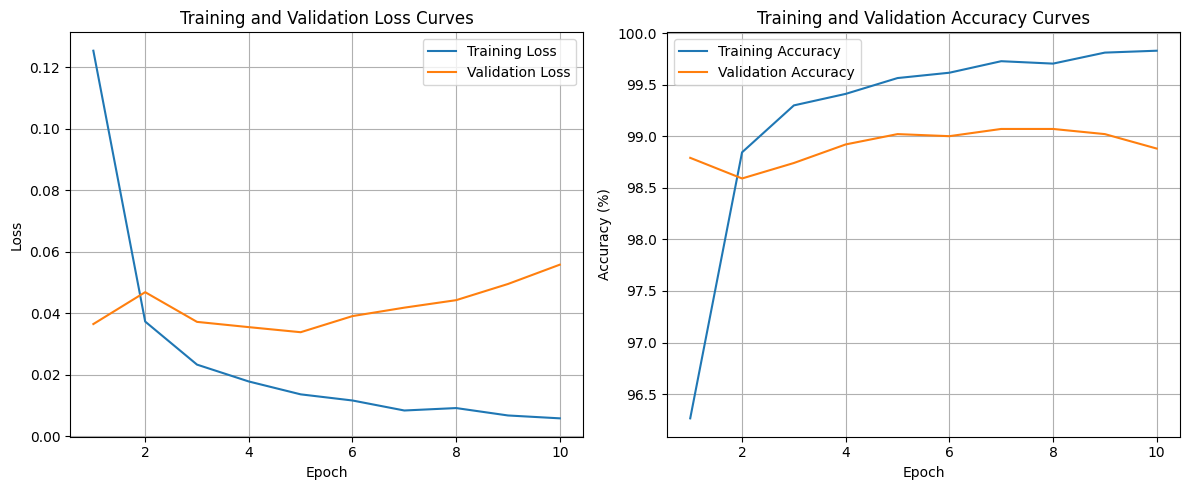

In [10]:
num_epochs = 10

import matplotlib.pyplot as plt

def train_and_evaluate_model(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    train_losses = []   # To store training losses for each epoch
    test_losses = []    # To store validation losses for each epoch
    train_accuracies = []  # To store training accuracies for each epoch
    test_accuracies = []   # To store validation accuracies for each epoch

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        # Calculate and store the average training loss and accuracy for this epoch
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Evaluate the model on the validation set
        model.eval()  # Set the model to evaluation mode
        test_loss = 0.0
        correct_test = 0
        total_test = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        # Calculate and store the average validation loss and accuracy for this epoch
        test_loss = test_loss / len(test_loader)
        test_losses.append(test_loss)
        test_accuracy = 100 * correct_test / total_test
        test_accuracies.append(test_accuracy)

        # Print statistics
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, '
              f'Validation Loss: {test_loss:.4f}, Validation Accuracy: {test_accuracy:.2f}%')

    print("Training complete.")
    
    # Plot training and validation loss and accuracy curves
    plt.figure(figsize=(12, 5))
    
    # Loss curves
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs+1), test_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss Curves')
    plt.grid(True)

    # Accuracy curves
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, num_epochs+1), test_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Training and Validation Accuracy Curves')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Call the modified training and evaluation function
train_and_evaluate_model(model, train_loader, test_loader, criterion, optimizer, num_epochs)


# Preparing Sudoku Test Images
The Sudoku test images are loaded, and individual cells are extracted, normalized, and resized to match the MNIST format for processing.



In [14]:
# Load the test images for Sudoku puzzles
file_path = '/kaggle/input/testdata/imgs.npy'  # Update with your file path
test_images = np.load(file_path)
print("Test Images Shape:", test_images.shape)

Test Images Shape: (10000, 252, 252)


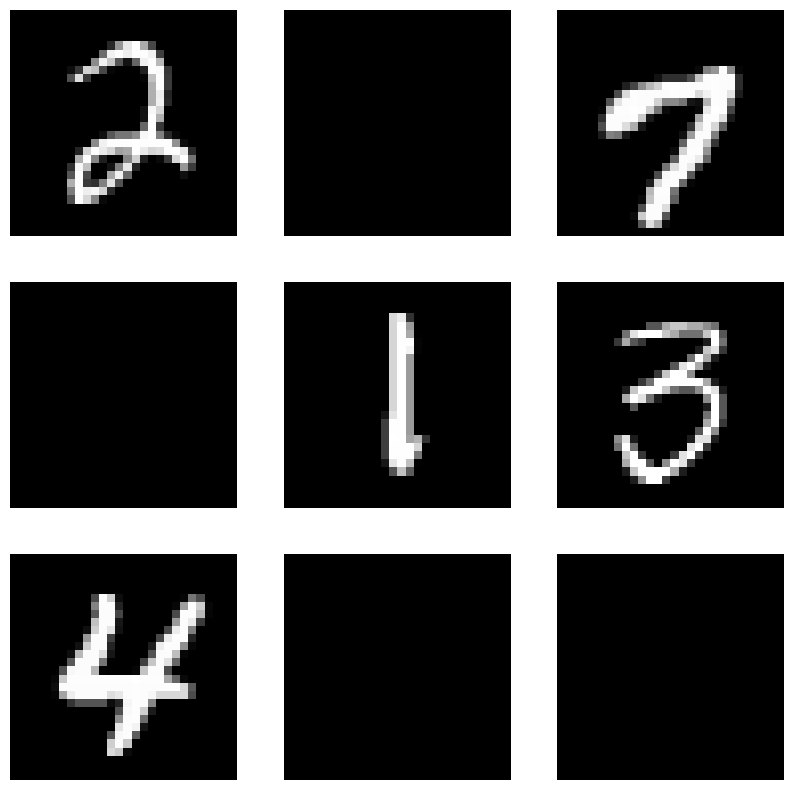

In [15]:
def extract_cells(image):
    cell_size = 28
    cells = []

    for i in range(9):  # 9 rows
        for j in range(9):  # 9 columns
            cell = image[i * cell_size:(i + 1) * cell_size, j * cell_size:(j + 1) * cell_size]
            cells.append(cell)

    return cells

# Example: Extract cells from the first test image
test_cells = extract_cells(test_images[0])

# Display the first few cells to verify
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(test_cells[i], cmap='gray')
    plt.axis('off')
plt.show()


In [16]:
# Define a transform function to resize and normalize the cells
cell_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Sudoku Digit Prediction
The pre-trained model is now utilized to predict the digits in each cell of the Sudoku puzzles. Cells are preprocessed, fed into the model, and the predicted digits are obtained.

In [18]:
def is_blank(cell, threshold=5):
    # A cell is considered blank if its average pixel value is below the threshold
    return cell.mean() < threshold

# Modify the preprocess_and_predict function to handle blank cells
def preprocess_and_predict(cell, model, device):
    # Check if the cell is blank
    if is_blank(cell):
        predicted_digit = 0  # Set predicted_digit to 0 for blank cells
    else:
        # Apply the transform to the cell
        cell = cell_transform(cell)
        cell = cell.unsqueeze(0).to(device)  # Add a batch dimension and send to device

        with torch.no_grad():
            model.eval()  # Set model to evaluation mode
            outputs = model(cell)
            _, predicted = torch.max(outputs, 1)
            predicted_digit = predicted.item()
    
    return predicted_digit


# Example: Preprocess and predict the digit in the first cell
predicted_digit = preprocess_and_predict(test_cells[0], model, device)
print("Predicted digit for the first cell:", predicted_digit)


Predicted digit for the first cell: 2


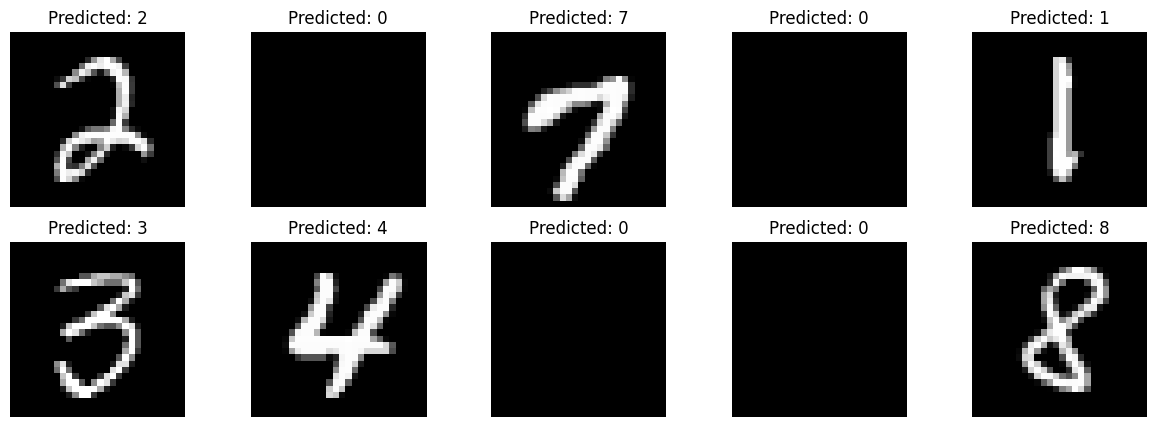

Predicted digits for the first 10 cells: [2, 0, 7, 0, 1, 3, 4, 0, 0, 8]


In [19]:
plt.figure(figsize=(15, 5))
predicted_digits = []

for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(test_cells[i], cmap='gray')
    plt.axis('off')

    if is_blank(test_cells[i]):
        predicted_digit = 0
    else:
        predicted_digit = preprocess_and_predict(test_cells[i], model, device)

    predicted_digits.append(predicted_digit)
    plt.title(f"Predicted: {predicted_digit}")

plt.show()

print("Predicted digits for the first 10 cells:", predicted_digits)

In [21]:
def process_all_images(test_images, model, device):
    predictions = []

    for img_id, image in enumerate(test_images):
        cells = extract_cells(image)
        for y in range(9):
            for x in range(9):
                cell_index = y * 9 + x
                cell = cells[cell_index]

                if is_blank(cell):
                    predicted_digit = 0
                else:
                    predicted_digit = preprocess_and_predict(cell, model, device)

                predictions.append(f"{img_id}_{y}{x},{predicted_digit}")

    return predictions

# Process all images and get predictions
all_predictions = process_all_images(test_images, model, device)

#Print the first few predictions
print(all_predictions[:10])

# Saving the predictions to a file
output_file_path = 'sudoku_predictions_task1.csv' 
with open(output_file_path, 'w') as f:
    f.write("id,value\n")
    for line in all_predictions:
        f.write(f"{line}\n")

print(f"Predictions saved to {output_file_path}")

['0_00,2', '0_01,0', '0_02,7', '0_03,0', '0_04,1', '0_05,3', '0_06,4', '0_07,0', '0_08,0', '0_10,8']
Predictions saved to sudoku_predictions_task1.csv


Kaggle Result for this approach: **0.99957**